
Latest version: 02-Jan-19 1:24 PM Cairo time

---



## Hyper-parameters and preamble




In [0]:
github = 'https://github.com/alkashef/flower-classification/'
repo_name = 'flower-classification'
project_name = 'identify_flower_species'
colab = True
verbose = True
reload_checkpoint = False
print_mini_batch = False
retrain_features = False

hp = {'input_layer'     : 2048,
      'hidden_layer_1'  : 1024,
      'hidden_layer_2'  : 512,
      'output_layer'    : 102,
      'learning_rate'   : 0.003,
      'no_epochs'       : 200,
      'batch_size'      : 128,
      'dropout_rate'    : 0.2,
      'num_workers'     : 0,
      'sample'          : 1,
      'base_model'      : 'resnet101'} # resnet34 # resnet50

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/alkashef/flower-classification/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [23]:
if colab:
    !pip install torch torchvision
    import torch
    
    #-------------------------------------------------------------------------------
    
    !pip uninstall -y Pillow
    !pip install Pillow==4.0.0
    !pip install PIL
    !pip install image

  Using cached https://files.pythonhosted.org/packages/14/41/db6dec65ddbc176a59b89485e8cc136a433ed9c6397b6bfe2cd38412051e/Pillow-6.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


Uninstalling Pillow-6.1.0:
  Successfully uninstalled Pillow-6.1.0
  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


  ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from google.colab import files

import numpy as np
from PIL import Image
import datetime
import time
import json
import os
import sys

## Test for CUDA

In [26]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if verbose:
    if not train_on_gpu:
        print('CUDA is not available. Training on CPU.')
    else:
        print('CUDA is available! Training on GPU.')

CUDA is available! Training on GPU.


## File paths

In [34]:
if colab: 
    !git clone $github
    project_dir = os.path.join('/content/', repo_name)
else:
    project_dir = os.getcwd()

data_dir = os.path.join(project_dir, 'data')
train_dir = os.path.join(data_dir, 'flower_data', 'train')
valid_dir = os.path.join(data_dir, 'flower_data', 'valid')

test_image = os.path.join(data_dir, 'test_image', 'flora.jpg')

checkpoints_path = os.path.join(project_dir, 'checkpoints') 
checkpoint_last = os.path.join(checkpoints_path, 'checkpoint_last.pth')
checkpoint_best = os.path.join(checkpoints_path, 'checkpoint_best.pth')
    
classes_dict = os.path.join(data_dir, 'cat_to_name.json')

if verbose:
    print("project_dir:", project_dir)
    print("train_dir:", train_dir)
    print("valid_dir:", valid_dir)
    print("checkpoints_path:", checkpoints_path)
    print("test_image:", test_image)
    print("classes_dict:", classes_dict)

fatal: destination path 'flower-classification' already exists and is not an empty directory.
project_dir: /content/flower-classification
train_dir: /content/flower-classification/data/flower_data/train
valid_dir: /content/flower-classification/data/flower_data/valid
checkpoints_path: /content/flower-classification/checkpoints
test_image: /content/flower-classification/data/test_image/flora.jpg
classes_dict: /content/flower-classification/data/cat_to_name.json


## Helper functions

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

#---------------------------------------------------------------------------------------

def print_dict(dict, sample=3):
    print(len(dict), 'categories')
    print("Sample categories:")
    ii = 1
    for (key, value) in dict.items():
        if (ii <= sample):
            print('\t{:3s} : {:s}'.format(key, value))
            ii = ii + 1

#---------------------------------------------------------------------------------------

def show_images(loader, sample=4, normalize=True):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(figsize=(20,sample), ncols=sample)
    for ii in range(sample):
        ax = axes[ii]
        #helper.imshow(images[ii], ax=ax, normalize=normalize)
        imshow(images[ii], ax=ax, normalize=normalize)

#---------------------------------------------------------------------------------------

def humanize_time(secs):
    mins, secs = divmod(secs, 60)
    hours, mins = divmod(mins, 60)
    return '%02d:%02d:%02d' % (hours, mins, secs)

#---------------------------------------------------------------------------------------

def plot_losses(train_losses, test_losses):
    plt.plot(test_losses, label="Validation")
    plt.plot(train_losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    val, index = torch.topk(torch.stack(test_losses), largest=False, k=1)
    print('Smallest validation loss at epoch', index.item())

#---------------------------------------------------------------------------------------

def print_checkpoint(checkpoint):
    for key, val in checkpoint.items():
        print(key, ":", val)

#---------------------------------------------------------------------------------------

def load_checkpoint(filepath, print=False):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])  
    if print: 
        print_checkpoint(checkpoint)
    return model, checkpoint['performance']

#---------------------------------------------------------------------------------------

def print_batch(label, e, no_epochs, b, no_batches):
    print("[%s] Epoch: %02d/%02d | %s batch: %03d/%03d" % \
          (datetime.datetime.now().strftime("%x %X"), 
           e+1, 
           no_epochs, 
           label, 
           b+1, 
           no_batches))

#---------------------------------------------------------------------------------------

def save_print_epoch(e, no_epochs, epoch_time, train_loss, test_loss, test_acc, best_acc, checkpoint):
    # save last
    checkpoint.update(hp)
    torch.save(checkpoint, checkpoint_last)
    
    # save best
    if (test_acc > best_acc):
        torch.save(checkpoint, checkpoint_best)
        best_saved = " (*)"
    else:
        best_saved = ''
        
    # print
    print("[%s] Epoch: %03d/%03d | %s | Train loss: %02.3f | Val loss: %02.3f | Val acc: %02.3f%s" % \
          (datetime.datetime.now().strftime("%x %X"),
           e+1, 
           no_epochs, 
           humanize_time(epoch_time), 
           train_loss, 
           test_loss, 
           test_acc,
           best_saved))

#---------------------------------------------------------------------------------------

def print_epoch_start(e, no_epochs):
    print("[%s] Epoch: %02d/%02d ..." % (datetime.datetime.now().strftime("%x %X"),e+1, no_epochs), end='\r')

#---------------------------------------------------------------------------------------

def plot_class_probs(probs, classes, cat_to_name):
    names = []
    for c in classes:
        names.append(cat_to_name[str(c)])
    names = tuple(names)
    fig, ax = plt.subplots()
    y_pos = np.arange(len(names))
    ax.barh(y_pos, probs)
    plt.yticks(y_pos, names)
    plt.show()

#---------------------------------------------------------------------------------------

def unfreeze(model, layer):
    print("Learnable parameters:")
    for name, param in model.named_parameters():
        if layer in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
        print("%-30s  |  %-5s" % (name, param.requires_grad))

#---------------------------------------------------------------------------------------

def list_layers(model):
    print("Learnable parameters:")
    for name, param in model.named_parameters():
        print(name)

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ColorJitter(hue=.02, saturation=.02),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Sample the train and test datasets individually 
train_length=int(hp['sample'] * len(train_data))
train_rest_length=len(train_data)-train_length

valid_length=int(hp['sample'] * len(valid_data))
valid_rest_length=len(valid_data)-valid_length

train_data_sample, train_data_rest = torch.utils.data.random_split(train_data, (train_length, train_rest_length))
valid_data_sample, valid_data_rest = torch.utils.data.random_split(valid_data, (valid_length, valid_rest_length))

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data_sample, 
                                           batch_size=hp['batch_size'], 
                                           num_workers=hp['num_workers'],
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data_sample, 
                                           batch_size=hp['batch_size'], 
                                           num_workers=hp['num_workers'])

In [0]:
train_size = len(train_data_sample)
valid_size = len(valid_data_sample)
total_size = train_size + valid_size
train_ratio = train_size / total_size
valid_ratio = valid_size / total_size

num_mini_batches, last_batch = divmod(train_size, train_loader.batch_size)
if last_batch > 0:
    num_mini_batches += 1
    
if verbose:
    print("Observations [Train:Validation] = %d:%d" % (train_size, valid_size))
    print("Ratio [Train:Validation] = %02.1f:%02.1f" % (train_ratio, valid_ratio))
    print("Training: %d (epochs) X %d (batches per epoch) X %d (observation per batch)" % (hp['no_epochs'], num_mini_batches, train_loader.batch_size))
    if last_batch > 0:
        print("          %d observations in last mini-batch" % (last_batch))

Observations [Train:Validation] = 6552:818
Ratio [Train:Validation] = 0.9:0.1
Training: 200 (epochs) X 52 (batches per epoch) X 128 (observation per batch)
          24 observations in last mini-batch


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [37]:
with open(classes_dict, 'r') as f:
    cat_to_name = json.load(f)

if verbose:
    print_dict(cat_to_name, sample=10)

102 categories
Sample categories:
	21  : fire lily
	3   : canterbury bells
	45  : bolero deep blue
	1   : pink primrose
	34  : mexican aster
	27  : prince of wales feathers
	7   : moon orchid
	16  : globe-flower
	25  : grape hyacinth
	26  : corn poppy


## Show train|valid samples

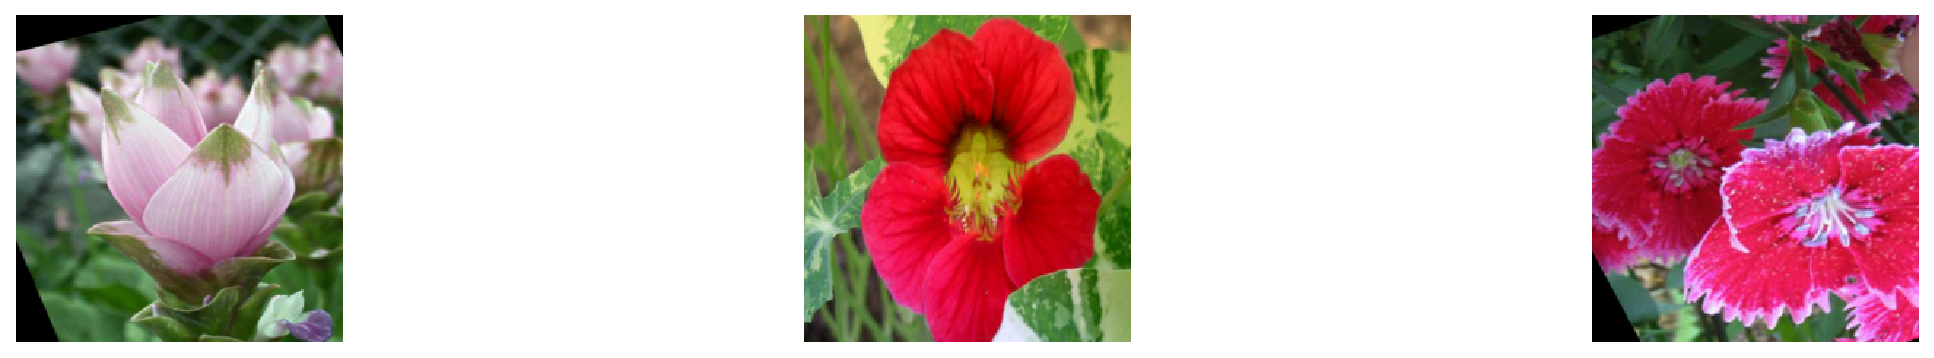

In [38]:
if verbose:
    show_images(loader=train_loader, sample=3, normalize=True)

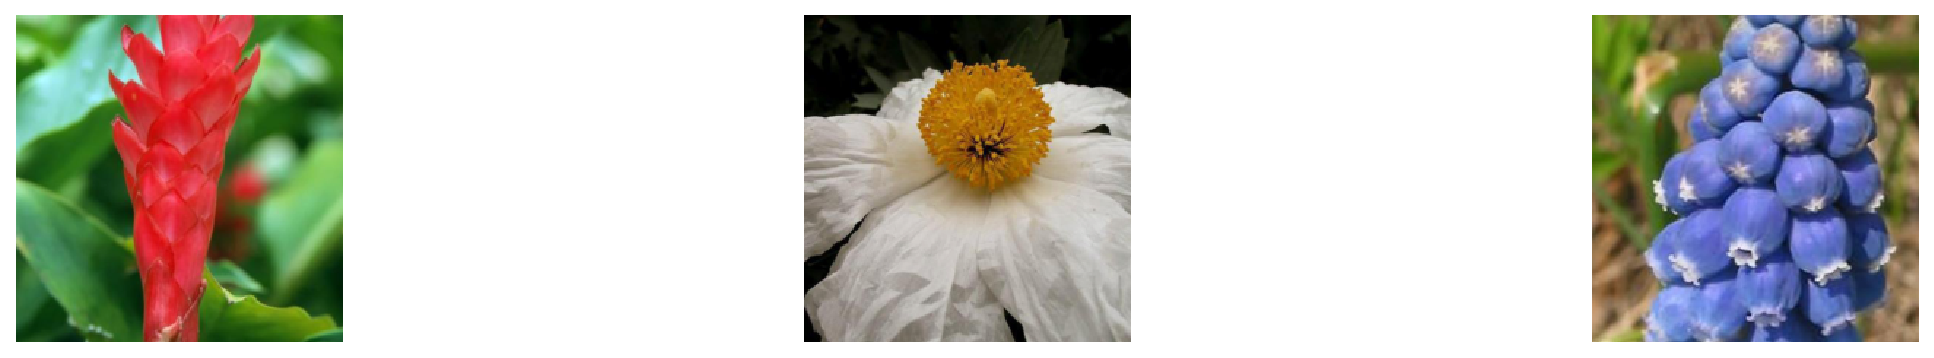

In [39]:
if verbose:
    show_images(loader=valid_loader, sample=3, normalize=True)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

## Load pre-trained model

In [40]:
if hp['base_model'] == 'resnet34':
    model = models.resnet34(pretrained=True)
elif hp['base_model'] == 'resnet50':
    model = models.resnet50(pretrained=True)
elif hp['base_model'] == 'resnet101':
    model = models.resnet101(pretrained=True)
else:
    model = models.resnet34(pretrained=True)
if verbose:
    print(model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:07<00:00, 22770233.00it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Prep pre-trained model for fine-tuning

In [42]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(hp['input_layer'], hp['hidden_layer_1'])),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(hp['dropout_rate'])),
                          ('fc2', nn.Linear(hp['hidden_layer_1'], hp['hidden_layer_2'])),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(hp['dropout_rate'])),
                          ('fc3', nn.Linear(hp['hidden_layer_2'], hp['output_layer'])),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = classifier

if verbose:
    print(model)

criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=hp['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Load model parameters from checkpoint

In [0]:
if reload_checkpoint:
    model, best_accuracy = load_checkpoint(checkpoint_best, print=verbose)
    if verbose:
        print(model)
else:
    best_accuracy = -1.0

## Retrain features

In [0]:
if retrain_features:
    hp['no_epochs'] = 30
    #list_layers(model)
    unfreeze(model, 'layer4.2')

## Move model to GPU

In [0]:
# Move pre-trained model to CUDA
if train_on_gpu:
    model.to('cuda')

## Fine-tuning the model

In [0]:
this_epoch_loss = 1e9
train_losses = [] 
test_losses = []
t_train = time.time()
    
if verbose:
    print("Starting accuracy:", best_accuracy)
    
train_batches = np.int(np.ceil(len(train_loader.dataset)/hp['batch_size']))
test_batches = np.int(np.ceil(len(valid_loader.dataset)/hp['batch_size']))

for e in range(hp['no_epochs']):
    t_epoch = time.time()
    train_loss_epoch = 0 # Per epoch
    
    if (not print_mini_batch):
        print_epoch_start(e, hp['no_epochs'])
        
    #---------------------------------------------------------------------------------
    # Training
    for b, (images, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        if print_mini_batch:
            print_batch('Training', e, hp['no_epochs'], b, train_batches)
        last_epoch_loss = this_epoch_loss
        optimizer.zero_grad()
        logits = model(images) 
        loss = criterion(logits, labels)
        train_loss_epoch += loss.item()
        loss.backward()
        optimizer.step()
    
    #---------------------------------------------------------------------------------
    # Validation
    else:      
        test_loss_epoch = 0 
        test_accuracy_epoch = 0
        
        epoch_time = time.time() - t_epoch
        
        with torch.no_grad():
            model.eval() # Switch-off dropout
        
            for b, (images, labels) in enumerate(valid_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                if print_mini_batch:
                    print_batch('Validation', e, hp['no_epochs'], b, test_batches)
                log_ps = model(images)
                test_loss_epoch += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy_epoch += torch.mean(equals.type(torch.FloatTensor))
        
        #---------------------------------------------------------------------------------
        
        model.train() # Switch-on dropout after validation
        
        #---------------------------------------------------------------------------------
        
        # Per epoch
        train_loss = train_loss_epoch/len(train_loader)
        test_loss = test_loss_epoch/len(valid_loader)
        test_accuracy = test_accuracy_epoch/len(valid_loader)
        test_accuracy = test_accuracy.item()
            
        scheduler.step(test_loss)
        
        #---------------------------------------------------------------------------------
        
        # For plotting losses
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        #---------------------------------------------------------------------------------
        
        #Saving checkpoint
        checkpoint = {'epoch': e,
                      'performance': test_accuracy,
                      'optimizer_state' : optimizer.state_dict,
                      'state_dict': model.state_dict()}
        
        save_print_epoch(e, 
                         hp['no_epochs'], 
                         epoch_time, 
                         train_loss, 
                         test_loss, 
                         test_accuracy, 
                         best_accuracy, 
                         checkpoint)
        
        #---------------------------------------------------------------------------------

        if (test_accuracy > best_accuracy):
            best_accuracy = test_accuracy
            
        #---------------------------------------------------------------------------------
              
train_time = time.time() - t_train
print("\nTotal time:", humanize_time(train_time))

Starting accuracy: -1.0
[07/25/19 15:42:14] Epoch: 001/200 | 00:02:50 | Train loss: 4.338 | Val loss: 2.790 | Val acc: 0.287 (*)
[07/25/19 15:45:23] Epoch: 002/200 | 00:02:49 | Train loss: 2.833 | Val loss: 1.995 | Val acc: 0.451 (*)


## Plot train & validation losses

Smallest validation loss at epoch 199


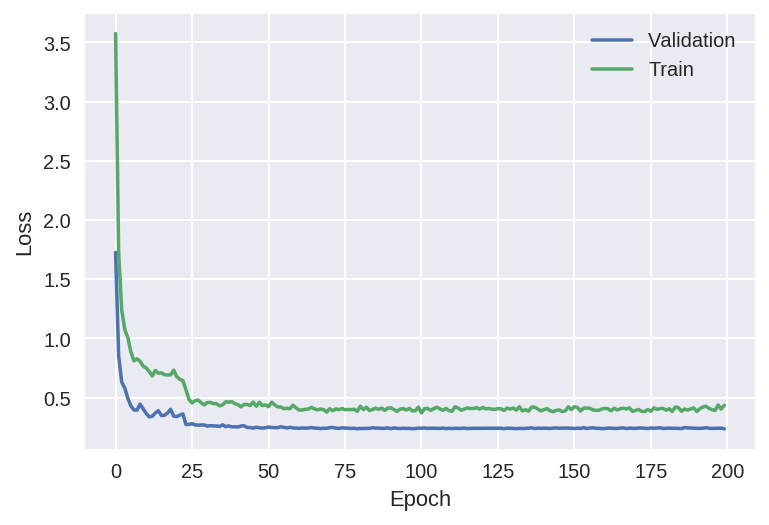

In [0]:
plot_losses(train_losses, test_losses)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
best_model, _ = load_checkpoint(checkpoint_best, print=verbose)

epoch : 133
performance : 0.9412053823471069
optimizer_state : <bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 3.0000000000000012e-09
    weight_decay: 0
)>
state_dict : OrderedDict([('conv1.weight', tensor([[[[ 0.0133,  0.0147, -0.0154,  ..., -0.0409, -0.0430, -0.0708],
          [ 0.0041,  0.0058,  0.0149,  ...,  0.0022, -0.0209, -0.0385],
          [ 0.0223,  0.0236,  0.0161,  ...,  0.1028,  0.0626,  0.0520],
          ...,
          [-0.0009,  0.0278, -0.0101,  ..., -0.1272, -0.0766,  0.0078],
          [ 0.0036,  0.0480,  0.0621,  ...,  0.0243, -0.0337, -0.0157],
          [-0.0800, -0.0322, -0.0178,  ...,  0.0354,  0.0224,  0.0017]],

         [[-0.0185,  0.0114,  0.0239,  ...,  0.0537,  0.0440, -0.0095],
          [-0.0077,  0.0189,  0.0680,  ...,  0.1596,  0.1461,  0.1200],
          [-0.0460, -0.0761, -0.0896,  ...,  0.1211,  0.1670,  0.1762],
          ...,
          [ 0.0288,  0.0137, -0.0838,  

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image, verbose=False):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    shortest_size = 256
    std = [0.229, 0.224, 0.225]
    means = [0.485, 0.456, 0.406]
    crop_size_w = 224
    crop_size_h = 224
    
    # Load image
    im = Image.open(image)
    if verbose:
        print("Image:", image, 
              "\nFormat:", im.format, 
              "\nSize:", im.size, 
              "\nMode:", im.mode,
              "\nBands:", im.getbands())
    
    # Resize image
    w = im.size[0]
    h = im.size[1]
    if w > h:
        ratio = shortest_size / h
    else:
        ratio = shortest_size / w
    new_size = (int(ratio * w), int(ratio * h))
    im.thumbnail(new_size)
    if verbose:
        print("Resize ratio:", ratio, 
              "\nSize after resizing:", im.size)
    
    # crop out the center 224x224 portion of the image.
    new_w, new_h = new_size
    left = (new_w - crop_size_w)/2
    top = (new_h - crop_size_h)/2
    right = (new_w + crop_size_w)/2
    bottom = (new_h + crop_size_h)/2
    im_cropped = im.crop((left, top, right, bottom))
    if verbose:
        print("Cropped size:", im_cropped.size)

    # Normalize color channels between 0-1
    np_image = np.array(im_cropped)/255
    
    # reoder dimensions
    np_image = np_image.transpose()
    
    # transform (normalize) image for the network
    for i in (0, 1, 2): # R/G/B channels
        np_image[[[i]]] = (np_image[[[i]]] - means[i])/std[i]

    if verbose:
        print("Processed image type:", type(np_image))
        print("Processed image shape:", np_image.shape)
    
    return(np_image)
    
processed_image = process_image(test_image, verbose=verbose)

Image: /content/drive/My Drive/Colab Notebooks/Final Challenge/data/test_image/flora.jpg 
Format: JPEG 
Size: (3482, 2321) 
Mode: RGB 
Bands: ('R', 'G', 'B')
Resize ratio: 0.11029728565273589 
Size after resizing: (384, 255)
Cropped size: (224, 224)
Processed image type: <class 'numpy.ndarray'>
Processed image shape: (3, 224, 224)


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

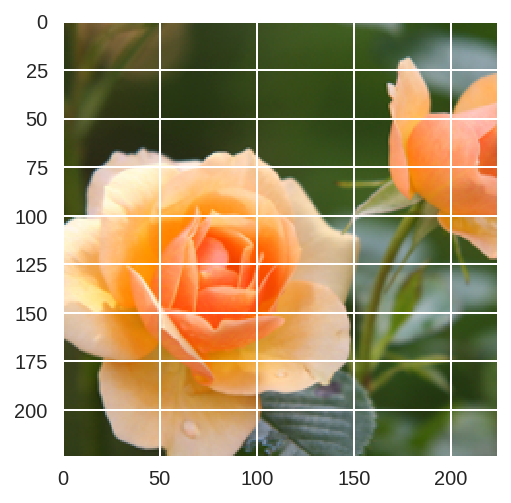

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose()
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image_tensor = torch.from_numpy(process_image(test_image))
imshow(image_tensor)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        Returns propabilities list and a classes list
    '''
    
    processed_image = torch.from_numpy(process_image(image_path)).unsqueeze(0)      
    
    model, _ = load_checkpoint(model)
    if train_on_gpu:
        model = model.type(torch.DoubleTensor)
    else:
        model = model.double()
      
    model.eval()
    log_ps = model(processed_image)
    ps = torch.exp(log_ps)
    probs, classes = ps.topk(topk, dim=1)
    return probs.data.numpy()[0].tolist(), classes.numpy()[0].tolist()

probs, classes = predict(test_image, checkpoint_best, topk=5)

if verbose:
    print("Probs:", probs)
    print("Classes:", classes)

Probs: [0.9999784048222762, 1.8597877216319317e-05, 1.7600128092499387e-06, 1.032445176770003e-06, 9.669267337880914e-08]
Classes: [74, 98, 40, 92, 3]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/alkashef/flower-classification/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

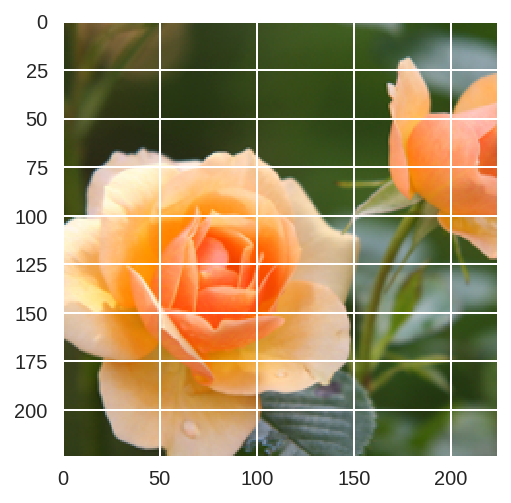

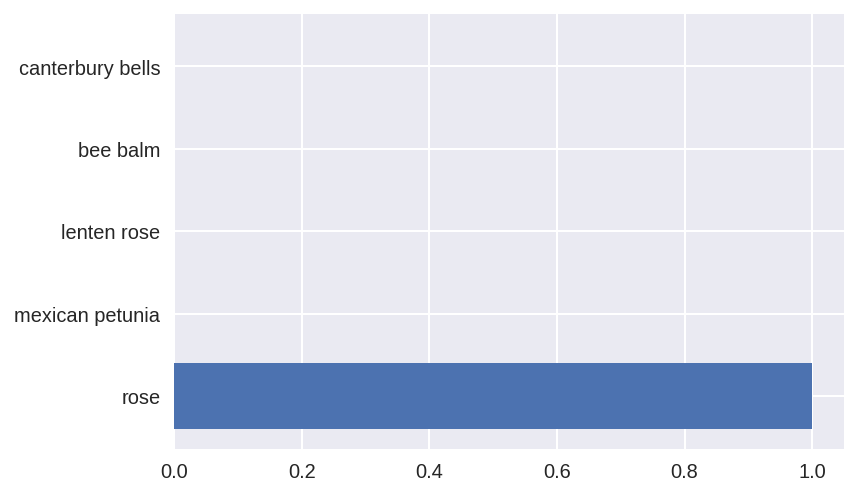

In [0]:
#@title
image_tensor = torch.from_numpy(process_image(test_image))
probs, classes = predict(test_image, checkpoint_best)
imshow(image_tensor)
plot_class_probs(probs, classes, cat_to_name)